In [144]:
import numpy as np
import pandas as pd
import data_cleaning as dc
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import quantile_transform
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error, auc, roc_curve, accuracy_score, matthews_corrcoef, f1_score 

# Ridge Regression Predictions 
## I. Define the "Trainer"

In [121]:
class RidgeRegression_classifer_trainer: 
    def __init__(self, df, target, norm=False, std=False, power_trans=False, cov_rem=False, DBSCAN_rem=False, quant_rem=False):
        X, y = df.drop(columns=[target]), df[target]
        
        X, self.mappings = self.data_encoding(X)
        
        # store all possible fields' name
        self.all_features = X.columns
        
        # convert data to ndarray
        X = X.values
        
        # methods to remove outliers 
        if cov_rem : 
            cov = EllipticEnvelope(random_state=0).fit(X)
            outliers_cov = cov.predict(X)
            X = X[outliers_cov != -1]
            y = y[outliers_cov != -1] 

        if DBSCAN_rem : 
            outlier_detection = DBSCAN(
                  eps = 1000,
                  metric="euclidean",
                  min_samples = 3)
            clusters = outlier_detection.fit_predict(X)
            X = X[clusters != -1]
            y = y[clusters != -1]
            print(clusters[clusters != -1].shape)


        if quant_rem : 
            X = quantile_transform(X, n_quantiles=10, random_state=0, copy=True)

        # applies a power transform to the data 
        if power_trans : 
            pt = PowerTransformer()
            X = pt.fit_transform(X)

        # if the data has to be standardize or normalize 
        X = self.pre_processing(X, norm, std)
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X,y, test_size=0.3,random_state=3)
        
        # intialize model
        self.model = None
        self.best_params = {}
        self.model_features = None
        self.pca = None
        
    def data_encoding(self, df): 
        mappings = {}
        for col in dc.non_numerical_features(df):
            df, mapping = dc.feature_ordinalEncoding(df, col)
            mappings[col] = mapping
        return df, mappings

    def pre_processing (self, data, norm=False, std=False) : 
        """
        Apply a transformation to the data. 
        Options are standardization or normalization (using L2 norm).
        By default : no transformation applied to data 
        """
        result = data
        if norm : 
            result = Normalizer().fit_transform(data)
        if std : 
            result = StandardScaler().fit_transform(data)
        return result
    
    def build_poly(self, x, degree):
        """
        Used to send the data in higher dimension using polynomial expansion
        :param x: the datapoint
        :param degree: the degree to which the datapoint is sent 
        """
        # send features in high dimension using polynomial expansion 
        poly = np.ones((len(x), 1))
        for deg in range(1, degree+1):
            poly = np.c_[poly, np.power(x, deg)]
        return poly

    def build_k_indices(self, y, k_fold, seed):
        """
        Builds k-indices for k-fold.
        """
        num_row = y.shape[0]
        interval = int(num_row / k_fold)
        np.random.seed(seed)
        indices = np.random.permutation(num_row)
        k_indices = [indices[k * interval: (k + 1) * interval]
                     for k in range(k_fold)]
        return np.array(k_indices)
    
    def find_best_params (self, X, y, learning_param_range, degrees, n_components):
        """
        Given a set of hyper-parameters, train multiple models using different parameter combinations, and returns the combination
        that yielded to the best result. 
        :param y: target 
        :param x: data
        :param learning_param_range: the learning parameter range for ridge regression
        :param n_components: the number of components used to reduce the number of features using PCA 
        """
        scores = []
        pcas = []
        minPCA_score_global = 9999999
        minPCA_value = n_components[-1]
        x_train, x_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3, random_state=3)
        for degree in degrees : 
            scores_pca = []
            for n_component in n_components : 
                pca = PCA(n_components = n_component)
                x_train_pca = pca.fit_transform(x_train, y_train)
                x_validation_pca = pca.transform(x_validation)
                polyTrain = self.build_poly(x_train_pca, degree)
                polyValidation = self.build_poly(x_validation_pca, degree)
                model = RidgeClassifierCV(alphas=learning_param_range, cv=4).fit(polyTrain, y_train)
                #print(model.score(polyTest, y_test))
                y_pred = model.predict(polyValidation) 
                error = mean_squared_error(y_validation, y_pred)
                scores_pca.append(error)

            minPca_Index = np.argmin(scores_pca)
            minPca_score = scores_pca[minPca_Index]

            #if (minPca_score < minPCA_score_global) : 
            #   minPCA_value = n_components[minPca_Index]
            scores.append(scores_pca[minPca_Index])
            pcas.append(n_components[minPca_Index])
        minIndex = np.argmin(scores)
        minDegree = degrees[minIndex]
        minScore = scores[minIndex]
        minPCA_value = pcas[minIndex]
        return minDegree, minScore, minPCA_value
    
    def get_selection_mask(self, selected_features):
        is_selected = lambda x, list_: True if x in list_ else False
        selection_mask = [is_selected(col, selected_features) for col in self.all_features]
        return selection_mask
    
    def train_model_on_best_params (self, learning_rates=[1e-2], degrees=[1], n_components=[5], features=None, end_evaluation=False) : 
        """
        Given a pre-set set of parameters, trains a model, keeps the model that had the best performance, and returns the 
        AuROC score of the best performing model. 
        """
        
        if features == None:
            features = self.all_features
        
        self.model_features = features
        
        selection_mask = self.get_selection_mask(features)
        
        minDegree, minScore, minPCA_value = self.find_best_params (self.X_train[:, selection_mask], 
                                                              self.y_train, 
                                                              learning_rates, degrees, n_components)

        self.best_params['degree'] = minDegree
        self.best_params['n_components'] = minPCA_value

        self.pca = PCA(n_components = minPCA_value)
        X_train_pca = self.pca.fit_transform(self.X_train[:, selection_mask], self.y_train)
        polyTrain = self.build_poly(X_train_pca, minDegree)
        self.model = RidgeClassifierCV(alphas=learning_params).fit(polyTrain, self.y_train)

        
        if end_evaluation:
            self.print_kpi(selection_mask)
        
        
    def print_kpi(self, selection_mask):
        x_test_pca = self.pca.transform(self.X_test[:, selection_mask])
        polyTest = self.build_poly(x_test_pca, self.best_params['degree'])
        y_pred = self.model.predict(polyTest)
        
        # plot some relevant KPI
        print('Accuracy: {:.2f}'.format(accuracy_score(y_pred, self.y_test)))
        print('MCC Score: {:.2f}'.format(matthews_corrcoef(self.y_test, y_pred)))
        print('F1 Score: {:.2f}'.format(f1_score(self.y_test, y_pred)))

        # plot ROC curve 
        decicion_weights = self.model.decision_function(polyTest)
        y_probs = np.exp(decicion_weights) / (1 + np.exp(decicion_weights))
        fpr, tpr, _ = roc_curve(self.y_test, y_probs)
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve - Area = {:.5f}".format(auc(fpr, tpr)));
       
    def get_model(self):
        return self.model
    
    def get_params(self):
        return self.best_params
       

## II. Perform some Testing

(7043,)
Accuracy: 0.81
MCC Score: 0.46
F1 Score: 0.56
{'degree': 1, 'n_components': 18}


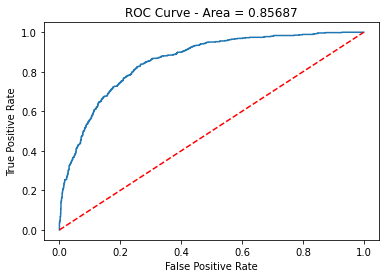

In [168]:
df = pd.read_csv("telco_data.csv")
target = 'Churn'
df['SeniorCitizen'] = df['SeniorCitizen'].astype(object)
df['Churn'] = df['Churn'].apply(lambda x: 0 if x == "No" else 1)
df = df.drop(columns=['customerID'])
target = 'Churn'

learning_rates = [ 0.001, 0.01, 0.1, 1, 2, 3]
degrees = [1, 2, 3]
n_components = [1, 5,15, 18]

RidgeRegression = RidgeRegression_classifer_trainer(df, target, power_trans=True, DBSCAN_rem=True)
RidgeRegression.train_model_on_best_params(learning_rates =learning_rates, degrees=degrees, n_components=n_components, end_evaluation=True)

print(RidgeRegression.get_params())

In [142]:
RidgeClassifierCV?